In [27]:
%matplotlib inline

import urllib, io, os

from skimage import filters

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import seaborn as sns

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from shapely.geometry import mapping, shape

from IPython.display import Image, display

import ee

ModuleNotFoundError: No module named 'cartopy'

In [26]:
!pip install cartopy

  Using cached https://files.pythonhosted.org/packages/e5/92/fe8838fa8158931906dfc4f16c5c1436b3dd2daf83592645b179581403ad/Cartopy-0.17.0.tar.gz
  Installing build dependencies ... done
  Running setup.py bdist_wheel for cartopy ... error
  Complete output from command /home/glaedur/anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-6o08zlct/cartopy/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-dtsv71l8 --python-tag cp36:
  /tmp/pip-install-6o08zlct/cartopy/setup.py:171: UserWarning: Unable to determine GEOS version. Ensure you have 3.3.3 or later installed, or installation may fail.
    '.'.join(str(v) for v in GEOS_MIN_VERSION), ))
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.6
  creating build/lib.linux-x86_64-3.6/cartopy
  copying lib/cartopy/__init__.py -> build/lib

Failed to build cartopy
  Running setup.py install for cartopy ... error
    Complete output from command /home/glaedur/anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-6o08zlct/cartopy/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /tmp/pip-record-kbcpvya8/install-record.txt --single-version-externally-managed --compile:
    /tmp/pip-install-6o08zlct/cartopy/setup.py:171: UserWarning: Unable to determine GEOS version. Ensure you have 3.3.3 or later installed, or installation may fail.
      '.'.join(str(v) for v in GEOS_MIN_VERSION), ))
    running install
    running build
    running build_py
    creating build
    creating build/lib.linux-x86_64-3.6
    creating build/lib.linux-x86_64-3.6/cartopy
    copying lib/cartopy/__init__.py -> build/lib.linux-x86_64-3.6/cartopy
    copying lib/cartopy/_epsg.py -> build/lib.linux-x86_64-3.6/cartopy
  

Command "/home/glaedur/anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-6o08zlct/cartopy/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /tmp/pip-record-kbcpvya8/install-record.txt --single-version-externally-managed --compile" failed with error code 1 in /tmp/pip-install-6o08zlct/cartopy/
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [28]:
ee.Initialize()


# Prosser Creek Reservoir
geometry = ee.Geometry.Polygon(
        [[[-120.17703806492915, 39.39640731015444],
          [-120.17695224301048, 39.36409996022785],
          [-120.12708745495274, 39.36409996023226],
          [-120.12751660052578, 39.39627465398903]]])

geometry_inset = ee.Geometry.Polygon(
        [[[-120.1688864489252, 39.37876210289311],
          [-120.15103213874107, 39.37869575274162],
          [-120.15120379263777, 39.38347282508428],
          [-120.16871480971241, 39.38380452980298]]])
        
vis = {'bands':['B6', 'B5', 'B3'], 'min':0.003, 'max': 0.35}
vis_rgb = {'bands': ['B4', 'B3', 'B2'], 'min':0.1, 'max':0.25}

start = '2013-10-18'
stop = '2013-10-19'

suffix = 'ProsserCreek'

removeShortEdges = True

resample = False

water_sigma = 1
water_threshold = 0.5

water_bands = ['B3', 'B6']

ndwi_hist_ymax = 5



In [29]:


# define location (Dubai)
geometry = ee.Geometry.Polygon(
        [[[54.94803425942996, 24.96652872736307],
          [55.033264838241735, 24.968551791222385],
          [55.03223484885575, 25.040348953381287],
          [54.94803425837563, 25.039649067823706]]])

geometry_inset = ee.Geometry.Polygon(
        [[[54.94979360928278, 24.973103768480218],
          [55.00944661871904, 24.973220470558697],
          [55.00987576282864, 24.99453789883235],
          [54.94979361672176, 24.994771272723373]]])
        
vis = {'bands':['B6', 'B5', 'B3'], 'min':0.05, 'max': 0.5}
vis_rgb = {'bands': ['B4', 'B3', 'B2'], 'min':0.1, 'max':0.4}

start = '2014-03-15'
stop = '2014-03-16'

removeShortEdges = False 

resample = True

suffix = 'Dubai'

water_bands = ['B3', 'B5']

water_threshold = 0.4
water_sigma = 1

ndwi_hist_ymax = 10



In [30]:
geometry = geometry.buffer(240).bounds()
# generate percentile composite image
images = ee.ImageCollection("LANDSAT/LC8_L1T_TOA") \
    .filterBounds(geometry)

# image = images \
#     .filterDate('2014-01-01', '2015-01-01') \
#     .map(lambda i: i.resample('bicubic')) \
#     .reduce(ee.Reducer.percentile([25])) \
#     .rename(ee.Image(images.first()).bandNames())

images = images.filterDate(start, stop)

if resample:
    images = images.map(lambda i: i.resample('bicubic'))

    
image = images.toList(1,0).get(0)    
    
image = ee.Image(image)
    
prj = ee.Image(images.first()).select(0).projection()

# image = image.reproject(prj)

In [31]:
bounds = shape(geometry.bounds().getInfo())
coords = list(bounds.boundary.coords)

xmin = coords[0][0]
xmax = coords[1][0]
ymin = coords[0][1]
ymax = coords[2][1]

extent = (xmin, xmax, ymin, ymax)

NameError: name 'shape' is not defined

In [32]:
image.select(0).projection().getInfo()

{'crs': 'EPSG:32640',
 'transform': [30.0, 0.0, 200985.0, 0.0, -30.0, 2834115.0],
 'type': 'Projection'}

In [33]:
def get_path(image):
    return image.getThumbURL({'region' : geometry.getInfo(), 'format': 'png', 'dimensions': 1024})

def retrieve(image, path_out):
    path = get_path(image)
    
    if os.path.exists(path_out):
            os.remove(path_out)
    
    urllib.request.urlretrieve(path, path_out)

def show(image, path_out):
    plt.grid(False)
    
    if path_out:
        retrieve(image, path_out)
        plt.imshow(plt.imread(path_out))
    else:
        display(Image(url=get_path(image)))

In [34]:
# get SWIR1_NIR_GREEN image
path_out = 'image_swir1_nir_green.png'

im = image.visualize(**vis)
urllib.request.urlretrieve(get_path(im), path_out)

# show image with cartopy
f=plt.figure(figsize=(10, 10))

ax2 = plt.subplot(212, projection=ccrs.GOOGLE_MERCATOR)
ax2.set_extent(extent)
ax2.set_xticks(np.linspace(xmin, xmax, 5), crs=ccrs.PlateCarree())
ax2.set_yticks(np.linspace(ymin, ymax, 5), crs=ccrs.PlateCarree())

# label axes as degrees
lon_formatter = LongitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax2.xaxis.set_major_formatter(lon_formatter)

lat_formatter = LatitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax2.yaxis.set_major_formatter(lat_formatter)

ax2.grid(False)

# show image
img = plt.imread(path_out)
ax2.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')

NameError: name 'ccrs' is not defined

<Figure size 720x720 with 0 Axes>

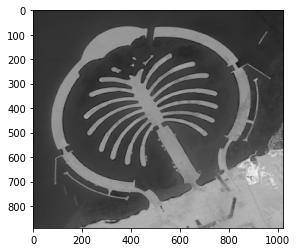

In [35]:
ndwi = image.normalizedDifference(water_bands)    

im = ee.ImageCollection.fromImages([
        ndwi.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']})
    ]).mosaic()

show(im, 'ndwi.png')

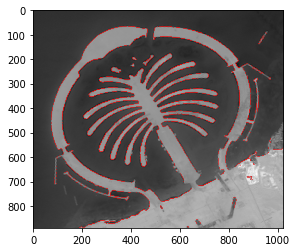

In [36]:
edge = ee.Algorithms.CannyEdgeDetector(ndwi, water_threshold, water_sigma)

# remove short edges
if removeShortEdges:
    connected = edge.mask(edge).lt(0.8).connectedPixelCount(35, True)
    edgeLong = connected.gte(35)
    edge = edgeLong

im = ee.ImageCollection.fromImages([
        ndwi.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']}),
        edge.focal_max(1).mask(edge.focal_max(1)).visualize(**{'palette':['ff0000']})
    ]).mosaic()

show(im, 'ndwi_edges.png')

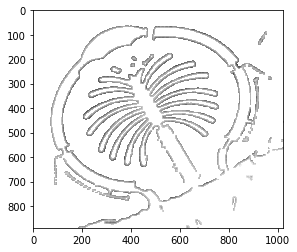

In [37]:
ndwi_buffer = ndwi.mask(edge.focal_max(30, 'square', 'meters'))

im = ee.ImageCollection.fromImages([
        ee.Image(1).visualize(**{'palette':['ffffff']}),
        ndwi_buffer.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']}),
    ]).mosaic()

show(im, 'ndwi_buffer.png')

0.0990027083984375


(-1, 1)

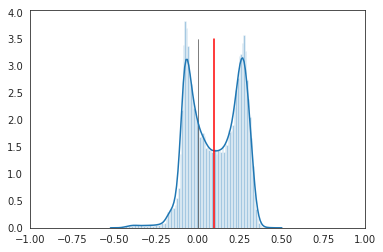

In [38]:
# local threshold
ndwi_buffer = ndwi.mask(edge.focal_max(30, 'square', 'meters'))

hist = ndwi_buffer.reduceRegion(ee.Reducer.histogram(150), geometry, 30).getInfo()

values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 15).getInfo()

th = filters.threshold_otsu(np.array(values['nd']))
print(th)

sns.set_style('white')
f = plt.figure()
plt.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02})
plt.plot([th, th], [0, 3.5], 'r-')
plt.xlim(-1, 1)

In [40]:
# detect water
water = ndwi.gt(th)
water_edge = ee.Algorithms.CannyEdgeDetector(water, 0.5, 0)

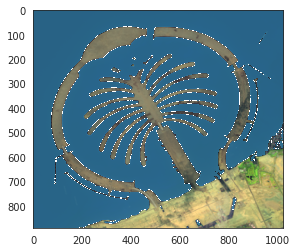

In [41]:
im = ee.ImageCollection.fromImages([
        image.visualize(**{'min':0.05, 'max':0.5, 'bands': ['B6', 'B5', 'B3']}),
        # image.visualize(**{'min':0.03, 'max':0.5, 'bands': ['B4', 'B3', 'B2']}),
        water.mask(water).visualize(**{'opacity':0.6, 'palette':['43a2ca']}),
        water_edge.mask(water_edge).visualize(**{'palette':['ffffff']}),
        
    ]).mosaic()

show(im, 'water_final.png')

In [43]:
from matplotlib import rc,rcParams


params = {
    'text.usetex': True,
    'text.latex.preamble' : [
        r'\usepackage{siunitx}', r'\usepackage{amsmath}',
        # r'\usepackage[T1]{fontenc}', r'\usepackage[utf8]{inputenc}',
        r'\usepackage{lmodern}', r'\usepackage{fourier}'

        # r'\usepackage{siunitx}', r'\usepackage{amsmath}', r'\usepackage{sansmath}', '\sansmath'
    ],
    'font.family' : 'lmodern',
    'text.latex.unicode': False,
}

    
plt.rcParams.update(params)

/home/glaedur/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [44]:
f = plt.figure(figsize=(12,3), dpi=600)
gs = gridspec.GridSpec(3, 5, height_ratios=[0.2,0.3,1] )

gs.update(wspace=0.02, hspace=0.02) # set the spacing between axes. 

    
# -------------------- row 1 (flowchart)
ax = plt.subplot(gs[0,0])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Compute Index', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,1])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Detect Edges', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,2])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Buffer', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,3])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Compute Threshold', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,4])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Threshold', fontweight='bold', fontsize=11, horizontalalignment='center')


# ---------------------- row 2 (equations)
ax = plt.subplot(gs[1,0])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$I=\dfrac{\rho_{nir}-\rho_{vis}}{\rho_{nir}+\rho_{vis}}$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,1])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$C=Canny\left(I,\sigma,th\right)$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,2])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$I_c=\left\{ I | I \in C \oplus S \right\}$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,3])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$T=Otsu(I_c)$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,4])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$T=Otsu(I_c)$', fontsize=10, ha='center', va='center')


# -------------------- row 3 (images)
ax = plt.subplot(gs[2,0], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
ax.set_xticks(np.linspace(xmin, xmax, 3), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(ymin, ymax, 3), crs=ccrs.PlateCarree())

# label axes as degrees
lon_formatter = LongitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax.xaxis.set_major_formatter(lon_formatter)

lat_formatter = LatitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax.yaxis.set_major_formatter(lat_formatter)

# show image
img = plt.imread('ndwi.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')




ax = plt.subplot(gs[2,1], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('ndwi_edges.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)


ax = plt.subplot(gs[2,2], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('ndwi_buffer.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)



ax = plt.subplot(gs[2,3])
ax.set_axis_off()
ax.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'], kde_kws={'bw': 0.02})
ax.plot([th, th], [0, 3.5], 'r-')
ax.set_xlim(-1, 1)
ax.set_axis_on()
ax.yaxis.set_visible(False)
# ax.text(, r'$I=\dfrac{\rho_{nir}-\rho_{vis}}{\rho_{nir}+\rho_{vis}}$', fontsize=10, ha='center', va='center')


ax = plt.subplot(gs[2,4], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('water_final.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

NameError: name 'ccrs' is not defined

/home/glaedur/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fcdf010ab70> (for post_execute):


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 7200x1800 with 10 Axes>

In [45]:
# save as high-dpi image
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages(r'../figures/water_detection_method_' + suffix + '.pdf')
pdf.savefig(figure=f, bbox_inches='tight', dpi=600)
pdf.close()

FileNotFoundError: [Errno 2] No such file or directory: '../figures/water_detection_method_Dubai.pdf'

In [46]:
f = plt.figure(figsize=(12, 3))

# show global threshold
values = ndwi.reduceRegion(ee.Reducer.toList(), geometry, 15).getInfo()
th = filters.threshold_otsu(np.array(values['nd']))
print(th)

ax1 = plt.subplot2grid((1,2),(0, 0))
ax1.plot([0, 0], [0, ndwi_hist_ymax], 'k-', lw=0.5)
sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02}, ax=ax1)
ax1.plot([th, th], [0, ndwi_hist_ymax], 'r-')
ax1.set_xlim(-1, 1)
ax1.set_title('Global NDWI frequency histogram')
ax1.text(-0.9, ndwi_hist_ymax * 0.9, 'NDWI=%.2f' % th)

# show local threthold
ndwi_buffer = ndwi.mask(edge.focal_max(30, 'square', 'meters'))
values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 15).getInfo()
th = filters.threshold_otsu(np.array(values['nd']))
print('Local thredhold: ', th)

ax2.grid()
ax2 = plt.subplot2grid((1,2),(0, 1))
ax2.plot([0, 0], [0, ymax], 'k-', lw=0.5)
sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02}, ax=ax2)
ax2.plot([th, th], [0, ymax], 'r-')
ax2.set_xlim(-1, 1)
ax2.set_title('Local NDWI freuency histogram around sharp NDWI edges')
ax2.text(-0.9, ndwi_hist_ymax * 0.9, 'NDWI=%.2f' % th)


ax1.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax1.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax1.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)
ax1.yaxis.set_major_locator(plt.MultipleLocator(1))
ax1.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax1.set_ylim(0, ndwi_hist_ymax)

ax2.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax2.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax2.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)
ax2.yaxis.set_major_locator(plt.MultipleLocator(1))
ax2.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax2.set_ylim(0, ndwi_hist_ymax)

f.subplots_adjust(wspace=0.1)

0.07973328458984374
Local thredhold:  0.0990027083984375


NameError: name 'ax2' is not defined

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fcdf010ab70> (for post_execute):


/home/glaedur/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 864x216 with 1 Axes>

In [47]:
# save as high-dpi image
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages(r'../figures/NDWI_hist_local_global_' + suffix + '.pdf')
pdf.savefig(figure=f, bbox_inches='tight', dpi=600)
pdf.close()

FileNotFoundError: [Errno 2] No such file or directory: '../figures/NDWI_hist_local_global_Dubai.pdf'

In [48]:
f = plt.figure(figsize=(12,5))

f.subplots_adjust(wspace=0.15, hspace=0.05)

ax1 = plt.subplot2grid((2,2), (0,0), rowspan=2, projection=ccrs.GOOGLE_MERCATOR)
ax2 = plt.subplot2grid((2,2), (0,1), projection=ccrs.GOOGLE_MERCATOR)
ax3 = plt.subplot2grid((2,2), (1,1), projection=ccrs.GOOGLE_MERCATOR)

def add_ticks(ax, nx, ny, xmin, xmax, ymin, ymax):
    ax.set_axis_on()
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_xticks(np.linspace(xmin, xmax, nx), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(ymin, ymax, ny), crs=ccrs.PlateCarree())
    
    # label axes as degrees
    lon_formatter = LongitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
    ax.xaxis.set_major_formatter(lon_formatter)
    lat_formatter = LatitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
    ax.yaxis.set_major_formatter(lat_formatter)


# main image
#im_rgb = image.visualize(**vis_rgb)
#retrieve(im_rgb, 'fig2_main.png')

im_rgb = image.visualize(**vis)
retrieve(im_rgb, 'fig2_main.png')

ax1.set_extent(extent)
img = plt.imread('fig2_main.png')
ax1.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')

add_ticks(ax1, 5, 5, xmin, xmax, ymin, ymax)


bounds = shape(geometry_inset.bounds().getInfo())
coords = list(bounds.boundary.coords)
xmin2 = coords[0][0]
xmax2 = coords[1][0]
ymin2 = coords[0][1]
ymax2 = coords[2][1]

extent2 = (xmin2, xmax2, ymin2, ymax2)

import matplotlib.patches as mpatches
ax1.add_patch(mpatches.Rectangle(xy=[xmin2, ymin2], width=xmax2-xmin2, height=ymax2-ymin2,
                                facecolor='None',
                                edgecolor='yellow',
                                lw=1,
                                transform=ccrs.PlateCarree())
             )


# NDWI = 0
edge = ee.Algorithms.CannyEdgeDetector(ndwi.gt(0), 1, 0)
ndwi_zero = edge.mask(edge).focal_max(1)

im = ee.ImageCollection.fromImages([
        im_rgb,
        ndwi_zero.visualize(**{'palette': 'ffffff'}),
    ]).mosaic()

thumb_url = im.getThumbURL({'region' : geometry_inset.getInfo(), 'format': 'png', 'dimensions': 800})
urllib.request.urlretrieve(thumb_url, 'fig2_ur.png')
    
img = plt.imread('fig2_ur.png')
ax2.set_extent(extent2)
ax2.imshow(img, transform=ccrs.PlateCarree(), extent=extent2, origin='upper')
ax2.set_axis_on()
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)

add_ticks(ax2, 4, 3, xmin2, xmax2, ymin2, ymax2)
ax2.xaxis.set_ticks([])
ax2.yaxis.tick_right()

# NDWI dynamic
edge = ee.Algorithms.CannyEdgeDetector(water, 1, 0)
ndwi_dynamic = edge.mask(edge).focal_max(1)

im = ee.ImageCollection.fromImages([
        im_rgb,
        ndwi_dynamic.visualize(**{'palette': 'ffffff'}),
    ]).mosaic()

thumb_url = im.getThumbURL({'region' : geometry_inset.getInfo(), 'format': 'png', 'dimensions': 800})
urllib.request.urlretrieve(thumb_url, 'fig2_lr.png')

img = plt.imread('fig2_lr.png')
ax3.set_extent(extent2)
ax3.imshow(img, transform=ccrs.PlateCarree(), extent=extent2, origin='upper')
ax3.set_axis_on()
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)

add_ticks(ax3, 4, 3, xmin2, xmax2, ymin2, ymax2)
ax3.yaxis.tick_right()

#plt.tight_layout()

NameError: name 'ccrs' is not defined

<Figure size 864x360 with 0 Axes>

In [49]:
# save as high-dpi image
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages(r'../figures/water_detection_method_zoom_' + suffix + '.pdf')
pdf.savefig(figure=f, bbox_inches='tight', dpi=600)
pdf.close()

FileNotFoundError: [Errno 2] No such file or directory: '../figures/water_detection_method_zoom_Dubai.pdf'

In [50]:
# show histogram around edges *without* resampling (scale=20)
images = ee.ImageCollection("LANDSAT/LC8_L1T_TOA")

image = images \
    .filterBounds(geometry) \
    .filterDate('2014-01-01', '2015-01-01') \
    .reduce(ee.Reducer.percentile([25])) \
    .rename(ee.Image(images.first()).bandNames())
    
ndwi = image.normalizedDifference(['B3', 'B5'])    
edge = ee.Algorithms.CannyEdgeDetector(ndwi, 0.5, 1)
ndwi_buffer = ndwi.mask(edge.focal_max(20, 'square', 'meters'))
values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 20).getInfo()
th = filters.threshold_otsu(np.array(values['nd']))
print(th)

sns.set_style('white')
f = plt.figure()
plt.plot([0, 0], [0, 9], 'k-', lw=0.5)

sns.distplot(values['nd'], bins=100)
plt.plot([th, th], [0, 9], 'r-')
plt.xlim(-1, 1)

0.19730533033203118


(-1, 1)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fcdf010ab70> (for post_execute):


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

In [51]:
# show histogram around edges *with* resampling (scale=20)
images = ee.ImageCollection("LANDSAT/LC8_L1T_TOA")

image = images \
    .filterBounds(geometry) \
    .filterDate('2014-01-01', '2015-01-01') \
    .map(lambda i: i.resample('bicubic')) \
    .reduce(ee.Reducer.percentile([25])) \
    .rename(ee.Image(images.first()).bandNames())
    
ndwi = image.normalizedDifference(['B3', 'B5'])    
edge = ee.Algorithms.CannyEdgeDetector(ndwi, 0.5, 1)
ndwi_buffer = ndwi.mask(edge.focal_max(20, 'square', 'meters'))
values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 20).getInfo()
th = filters.threshold_otsu(np.array(values['nd']))
print(th)

sns.set_style('white')
f = plt.figure()
plt.plot([0, 0], [0, 9], 'k-', lw=0.5)

sns.distplot(values['nd'], bins=100)
plt.plot([th, th], [0, 9], 'r-')
plt.xlim(-1, 1)


0.21003646443359375


(-1, 1)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fcdf010ab70> (for post_execute):


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>